In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

import numpy as np

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

## Loading the data

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/rice-diseases-image-dataset/LabelledRice/Labelled",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3355 files belonging to 4 classes.


In [9]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
105


In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.0, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


84
0
21


In [12]:
# runtime optimization
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# image preprocessing

# rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
#data_augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Loadding

In [16]:
from tensorflow import keras
loded_model = keras.models.load_model('../input/cnn-final/cnn_final.h5')

In [17]:
loded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 16)       

In [18]:
print(loded_model.layers)
print(loded_model.layers[14])

[<keras.engine.sequential.Sequential object at 0x7fca68b9d9d0>, <keras.layers.convolutional.Conv2D object at 0x7fca452df6d0>, <keras.layers.pooling.MaxPooling2D object at 0x7fca45297a10>, <keras.layers.convolutional.Conv2D object at 0x7fca452df950>, <keras.layers.pooling.MaxPooling2D object at 0x7fca452da490>, <keras.layers.convolutional.Conv2D object at 0x7fca45305e50>, <keras.layers.pooling.MaxPooling2D object at 0x7fca452f98d0>, <keras.layers.convolutional.Conv2D object at 0x7fca452fc250>, <keras.layers.pooling.MaxPooling2D object at 0x7fca452eaa10>, <keras.layers.convolutional.Conv2D object at 0x7fca452f6090>, <keras.layers.pooling.MaxPooling2D object at 0x7fca452388d0>, <keras.layers.convolutional.Conv2D object at 0x7fca4534b350>, <keras.layers.pooling.MaxPooling2D object at 0x7fca452d3610>, <keras.layers.core.Flatten object at 0x7fca4532cad0>, <keras.layers.core.Dense object at 0x7fca45247f90>, <keras.layers.core.Dense object at 0x7fca452f9e10>]


## CNN Model


### Prediction function

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Creating predicted and actual array

In [20]:
predicted = []
actual = []

for images, labels in test_ds:
    for i in range(len(labels)):
        predicted_class, confidence = predict(loded_model, images[i].numpy())
        predicted.append(predicted_class)
        actual_class = class_names[labels[i]] 
        actual.append(actual_class)

2022-11-08 18:09:49.539815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-08 18:09:59.582601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 201 of 256
2022-11-08 18:10:02.172953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-08 18:10:03.693404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-11-08 18:10:09.651342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 5 of 10000
2022-11-08 18:10:20.935907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 12 of 10000
2022-11-08 18:10:29.652880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 18 of

In [21]:
print(len(actual))
print(predicted)

672
['Healthy', 'BrownSpot', 'Hispa', 'Healthy', 'Healthy', 'BrownSpot', 'BrownSpot', 'Healthy', 'Hispa', 'LeafBlast', 'Hispa', 'Healthy', 'Healthy', 'BrownSpot', 'Healthy', 'Healthy', 'Healthy', 'LeafBlast', 'Healthy', 'LeafBlast', 'Healthy', 'Healthy', 'LeafBlast', 'Hispa', 'Healthy', 'Hispa', 'Healthy', 'Healthy', 'Healthy', 'BrownSpot', 'BrownSpot', 'LeafBlast', 'BrownSpot', 'Healthy', 'Healthy', 'Hispa', 'Healthy', 'Hispa', 'Hispa', 'Hispa', 'Healthy', 'Healthy', 'LeafBlast', 'Healthy', 'Hispa', 'Hispa', 'Healthy', 'LeafBlast', 'Healthy', 'Healthy', 'BrownSpot', 'Hispa', 'Healthy', 'Healthy', 'Hispa', 'BrownSpot', 'Healthy', 'LeafBlast', 'BrownSpot', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'BrownSpot', 'Hispa', 'Healthy', 'Hispa', 'Healthy', 'Healthy', 'Healthy', 'BrownSpot', 'LeafBlast', 'LeafBlast', 'LeafBlast', 'BrownSpot', 'Healthy', 'Healthy', 'Healthy', 'Hispa', 'Hispa', 'Hispa', 'Hispa', 'Healthy', 'BrownSpot', 'Hispa', 'Healthy', 'LeafBlast', 'Healthy', 'LeafBlast', 'H

<AxesSubplot:>

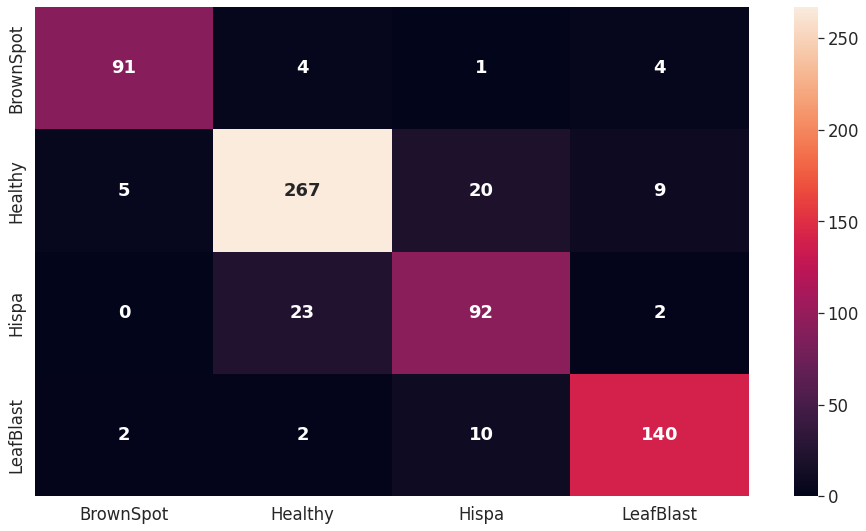

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize = (16,9))
cm = confusion_matrix(actual, predicted)

sns.set(font_scale=1.5)
sns.heatmap(cm, 
            annot = True,
            fmt = 'd',
            annot_kws={
                'fontsize': 18,
                'fontweight': 'bold',
                'fontfamily': 'Times New Roman'
            },
            xticklabels = class_names,
            yticklabels = class_names,
           )


In [23]:
from sklearn.metrics import classification_report
cr = classification_report(actual, 
                           predicted, 
                           target_names = class_names
                          )

In [24]:
print(cr)

              precision    recall  f1-score   support

   BrownSpot       0.93      0.91      0.92       100
     Healthy       0.90      0.89      0.89       301
       Hispa       0.75      0.79      0.77       117
   LeafBlast       0.90      0.91      0.91       154

    accuracy                           0.88       672
   macro avg       0.87      0.87      0.87       672
weighted avg       0.88      0.88      0.88       672



## CNN feature extractor

In [25]:
model_input = loded_model.input
print(model_input)
model_output= loded_model.layers[14].output
print(model_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sequential_input'), name='sequential_input', description="created by layer 'sequential_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='dense/Relu:0', description="created by layer 'dense'")


In [26]:
## feature extractor model
from keras.models import Model

# new model
feat_extractor_model = Model(inputs = model_input,
                             outputs = model_output )


## Creating datasets for svm

In [27]:
X_train_for_SVM = feat_extractor_model.predict(train_ds)
X_test_for_SVM = feat_extractor_model.predict(test_ds)

y_train = []
for images, labels in train_ds:
    for i in range(len(labels)):
        y_train.append(labels[i])

y_test = []
for images, labels in test_ds:
    for i in range(len(labels)):
        y_test.append(labels[i])

print(len(X_train_for_SVM))
print(len(X_test_for_SVM))
print(len(y_train))
print(len(y_test))

2022-11-08 18:13:12.940262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 216 of 256
2022-11-08 18:13:14.674459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-08 18:13:16.303491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-11-08 18:13:23.679844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 6 of 10000
2022-11-08 18:13:33.949161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13 of 10000
2022-11-08 18:13:44.477539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 20 of 10000
2022-11-08 18:13:53.769294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 26 of 10000


2683
672
2683
672


In [28]:
from sklearn.svm import SVC
svc = SVC(C=6, kernel= 'rbf' , gamma='scale')

In [29]:
# traing the model
svc.fit(X_train_for_SVM, y_train)

SVC(C=6)

In [30]:
# model prediction
predicted = svc.predict(X_test_for_SVM)

In [31]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,predicted))

Accuracy on unknown data is 0.8898809523809523


<AxesSubplot:>

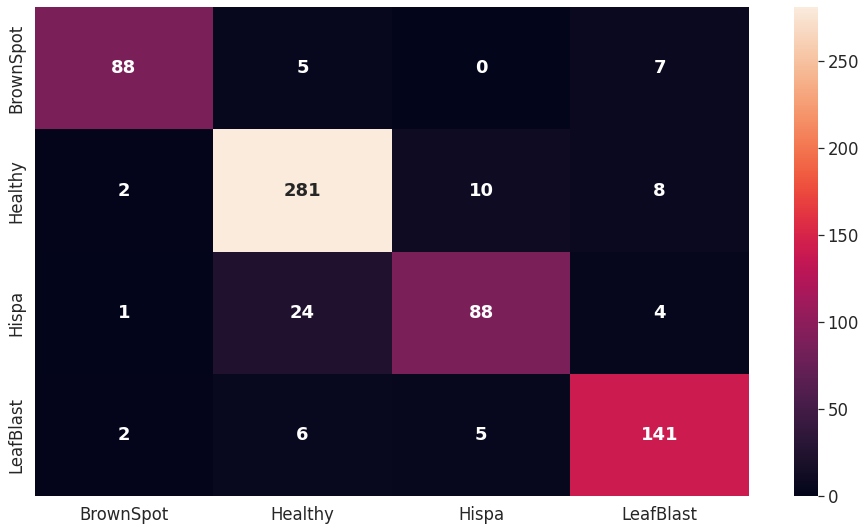

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize = (16,9))
cm = confusion_matrix(y_test, predicted)

sns.set(font_scale=1.5)
sns.heatmap(cm, 
            annot = True,
            fmt = 'd',
            annot_kws={
                'fontsize': 18,
                'fontweight': 'bold',
                'fontfamily': 'Times New Roman'
            },
            xticklabels = class_names,
            yticklabels = class_names,
           )


In [33]:
from sklearn.metrics import classification_report
print("Class Name",classification_report(y_test,predicted))

Class Name               precision    recall  f1-score   support

           0       0.95      0.88      0.91       100
           1       0.89      0.93      0.91       301
           2       0.85      0.75      0.80       117
           3       0.88      0.92      0.90       154

    accuracy                           0.89       672
   macro avg       0.89      0.87      0.88       672
weighted avg       0.89      0.89      0.89       672



In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


for i in range(50):
    regu = i+1
    print(regu, "-------------------------->")
    svc = SVC(C=regu, kernel= 'rbf' , gamma='scale')
    
    svc.fit(X_train_for_SVM, y_train)
    predicted = svc.predict(X_test_for_SVM)
    print("Class Name",classification_report(y_test,predicted))

1 -------------------------->
Class Name               precision    recall  f1-score   support

           0       0.86      0.85      0.85       100
           1       0.84      0.93      0.88       301
           2       0.83      0.61      0.70       117
           3       0.85      0.86      0.85       154

    accuracy                           0.85       672
   macro avg       0.84      0.81      0.82       672
weighted avg       0.84      0.85      0.84       672

2 -------------------------->
Class Name               precision    recall  f1-score   support

           0       0.91      0.87      0.89       100
           1       0.86      0.92      0.89       301
           2       0.83      0.68      0.75       117
           3       0.87      0.88      0.87       154

    accuracy                           0.86       672
   macro avg       0.86      0.84      0.85       672
weighted avg       0.86      0.86      0.86       672

3 -------------------------->
Class Name        